# Notebook 04:
Merging data and visualization:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

C:\Users\merto\AppData\Local\Temp\ipykernel_10736\2925721277.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Step1:

Combining previous DataFrames (all_rads, humidity_frame, temperature_frame,\
theoretical_radiation) together:

In [2]:
# Loading previous data:

with open(r'..\data\interim\01_reading_data\all_rads.pkl', 'rb') as f:
    all_rads= pickle.load(f)

with open(r'..\data\external\02_fetching_mathematica\humidity_frame.pkl', 'rb') as f:
    humidity_frame = pickle.load(f)

with open(r'..\data\external\02_fetching_mathematica\temperature_frame.pkl', 'rb') as f:
    temperature_frame = pickle.load(f)

with open(r'..\data\external\03_theoretical_radiation\theoretical_radiations.pkl', 'rb') as f:
    theoretical_radiation = pickle.load(f)

In [3]:
all_rads.head()

time city  radiation
0 1993-01-01  BND      12.62
1 1993-01-01  ESF      12.90
3 1993-01-01  KRM      13.38
4 1993-01-01  MSH      10.42
5 1993-01-01  SHZ      14.62

In [4]:
# The radiation column of all_rads DataFrame contains the available radiation values,
# So it's name should be changed to ava_rad.

all_rads.rename(columns={'radiation':'ava_rad'}, inplace=True)

all_rads.head()

time city  ava_rad
0 1993-01-01  BND    12.62
1 1993-01-01  ESF    12.90
3 1993-01-01  KRM    13.38
4 1993-01-01  MSH    10.42
5 1993-01-01  SHZ    14.62

In [5]:
# Temperature & relative humidity values from Dataframes temperature_frame
# and humidity_frame should be added to the all_rads DataFrame.

def add_temperature(row):
    return temperature_frame.loc[row.time, row.city]

all_rads['temp'] = all_rads.apply(add_temperature, axis=1)

def add_humidity(row):
    return humidity_frame.loc[row.time, row.city]

all_rads['rel_hum'] = all_rads.apply(add_humidity, axis=1)

all_rads.head()

time city  ava_rad   temp  rel_hum
0 1993-01-01  BND    12.62  19.11    0.782
1 1993-01-01  ESF    12.90   0.44    0.462
3 1993-01-01  KRM    13.38   4.83    0.576
4 1993-01-01  MSH    10.42  -0.06    0.732
5 1993-01-01  SHZ    14.62   4.61    0.602

In [6]:
# Since the temperature_frame and humidity_frame contain Nan values,
# Nan values may have been added to the all_rads DataFrame, so we should
# Omit possible added Nan values.

all_rads.dropna(inplace=True)

In [7]:
# Extracting year, month and day of year from the time column,
# and adding them to the all_rads DataFrame.

all_rads['year'] = all_rads.time.apply(lambda x: x.year)
all_rads['month'] = all_rads.time.apply(lambda x: x.month)
all_rads['dom'] = all_rads.time.dt.day #dom stands for day of month
all_rads['doy'] = all_rads.time.apply(lambda x: x.day_of_year) #doy stands for day of year

all_rads.head()

time city  ava_rad   temp  rel_hum  year  month  dom  doy
0 1993-01-01  BND    12.62  19.11    0.782  1993      1    1    1
1 1993-01-01  ESF    12.90   0.44    0.462  1993      1    1    1
3 1993-01-01  KRM    13.38   4.83    0.576  1993      1    1    1
4 1993-01-01  MSH    10.42  -0.06    0.732  1993      1    1    1
5 1993-01-01  SHZ    14.62   4.61    0.602  1993      1    1    1

In [8]:
# Since the spells of yazd city in DataFrames all_rads and theoretical_radiations
# are not the same, we have to change the spells to a unique name.

all_rads.replace('yazd', 'YAZD', inplace=True)
theoretical_radiation.rename(columns={'Yazd': 'YAZD'}, inplace=True)

In [9]:
# Adding extraterrestrial IR radiation to all_rads DataFrame,
# from the theoretical_radiation DataFrame.

def add_et_ir(row):
    return theoretical_radiation.loc[row.doy, row.city]

all_rads['et_rad'] = all_rads.apply(add_et_ir, axis=1)

all_rads.head()

time city  ava_rad   temp  rel_hum  year  month  dom  doy     et_rad
0 1993-01-01  BND    12.62  19.11    0.782  1993      1    1    1  21.652331
1 1993-01-01  ESF    12.90   0.44    0.462  1993      1    1    1  18.352701
3 1993-01-01  KRM    13.38   4.83    0.576  1993      1    1    1  19.798337
4 1993-01-01  MSH    10.42  -0.06    0.732  1993      1    1    1  16.104011
5 1993-01-01  SHZ    14.62   4.61    0.602  1993      1    1    1  20.216349

In [10]:
# Adding absolute humidity to all_rads DataFrame.
# The t_sh dictionary maps temperature(degree celsius) to saturated humidity(g/kg).

t_sh = {
    -25:0.706, -24:0.769, -23:0.837, -22:0.911, -21:0.990, -20:1.075,
    -19:1.167, -18:1.265, -17:1.371, -16:1.485, -15:1.607, -14:1.737,
    -13:1.877, -12:2.027, -11:2.188, -10:2.360, -9:2.543, -8:2.739,
    -7:2.948, -6:3.171, -5:3.409, -4:3.662, -3:3.932, -2:4.219, -1:4.524,
    0:4.849, 1:5.193, 2:5.560, 3:5.948, 4:6.360, 5:6.797, 6:7.260, 7:7.750,
    8:8.269, 9:8.818, 10:9.398, 11:10.011, 12:10.660, 13:11.343, 14:12.065,
    15:12.826, 16:13.630, 17:14.474, 18:15.365, 19:16.303, 20:17.290, 21:18.328,
    22:19.420, 23:20.566, 24:21.770, 25:23.037, 26:24.364, 27:25.760, 28:27.220,
    29:28.750, 30:30.355, 31:32.036, 32:33.796, 33:35.64, 34:37.566, 35:39.580,
    36:41.690, 37:43.890, 38:46.190, 39:48.590, 40:51.100, 41:53.72, 42:56.450,
    43:59.290, 44:62.260, 45:65.350, 46:68.570, 47:71.920, 48:75.410, 49:79.050,
    50:82.830}

sat_hum = all_rads.temp.apply(lambda x: t_sh[round(x)])
all_rads['abs_hum'] = sat_hum * all_rads.rel_hum

all_rads.head()

time city  ava_rad   temp  rel_hum  year  month  dom  doy     et_rad  \
0 1993-01-01  BND    12.62  19.11    0.782  1993      1    1    1  21.652331   
1 1993-01-01  ESF    12.90   0.44    0.462  1993      1    1    1  18.352701   
3 1993-01-01  KRM    13.38   4.83    0.576  1993      1    1    1  19.798337   
4 1993-01-01  MSH    10.42  -0.06    0.732  1993      1    1    1  16.104011   
5 1993-01-01  SHZ    14.62   4.61    0.602  1993      1    1    1  20.216349   

     abs_hum  
0  12.748946  
1   2.240238  
3   3.915072  
4   3.549468  
5   4.091794

In [11]:
# Adding clearness index(kt) to the DataFrame.
# Omiting samples with kt >= 1 values.

all_rads['kt'] = all_rads.ava_rad / all_rads.et_rad
all_rads = all_rads.where(all_rads.kt < 1).dropna()

all_rads.head()

time city  ava_rad   temp  rel_hum    year  month  dom  doy  \
0 1993-01-01  BND    12.62  19.11    0.782  1993.0    1.0  1.0  1.0   
1 1993-01-01  ESF    12.90   0.44    0.462  1993.0    1.0  1.0  1.0   
3 1993-01-01  KRM    13.38   4.83    0.576  1993.0    1.0  1.0  1.0   
4 1993-01-01  MSH    10.42  -0.06    0.732  1993.0    1.0  1.0  1.0   
5 1993-01-01  SHZ    14.62   4.61    0.602  1993.0    1.0  1.0  1.0   

      et_rad    abs_hum        kt  
0  21.652331  12.748946  0.582847  
1  18.352701   2.240238  0.702894  
3  19.798337   3.915072  0.675814  
4  16.104011   3.549468  0.647044  
5  20.216349   4.091794  0.723177

In [12]:
# As the doy value is a parameter that shows a periodic event,
# it's better to transform it's values from linear to a sine distribution.

def doy_to_sin(doy):
    '''
    Convert the Doy values in the data to a sine wave.
    '''
    
    results = doy + 10
    results = np.sin(doy * (np.pi / 365))
    results = np.abs(results)
    results = np.round(results, decimals=3)
    return results

all_rads['doysin'] = all_rads.doy.apply(doy_to_sin)

In [13]:
# Changing columns order of the all_rads DataFrame.
# Changing DataFrame name form all_rads to data.

all_rads = all_rads[['time', 'year', 'month', 'dom', 'doy', 'doysin', 'city',
                     'temp', 'rel_hum', 'abs_hum', 'ava_rad','et_rad', 'kt']]
data = all_rads

data.head()

time    year  month  dom  doy  doysin city   temp  rel_hum    abs_hum  \
0 1993-01-01  1993.0    1.0  1.0  1.0   0.009  BND  19.11    0.782  12.748946   
1 1993-01-01  1993.0    1.0  1.0  1.0   0.009  ESF   0.44    0.462   2.240238   
3 1993-01-01  1993.0    1.0  1.0  1.0   0.009  KRM   4.83    0.576   3.915072   
4 1993-01-01  1993.0    1.0  1.0  1.0   0.009  MSH  -0.06    0.732   3.549468   
5 1993-01-01  1993.0    1.0  1.0  1.0   0.009  SHZ   4.61    0.602   4.091794   

   ava_rad     et_rad        kt  
0    12.62  21.652331  0.582847  
1    12.90  18.352701  0.702894  
3    13.38  19.798337  0.675814  
4    10.42  16.104011  0.647044  
5    14.62  20.216349  0.723177

In [14]:
# Pickling data as combined_data.pkl
# This data is not cleaned.

with open(r'..\data\interim\04_data_merging\combined_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Finding outliers:

In [15]:
# Samples witch are 2 times of STD further from the mean are cosidered outliers.
# Saving upper and lower limits of outliers for each city in limits dictionary.

cities = data.city.unique()
limits = {}

# Upper and lower limits are calculated for each city.
for city in cities:
    kt = data[data.city == city]['kt']
    mean, std = kt.mean(), kt.std()
    lower, upper = mean - 2*std, mean + 2*std
    limits[city] = {'lower':lower, 'upper':upper}

# Upper and lower limits are added to the DataFrame.
data.loc[:, 'lower'] = data.city.apply(lambda x: limits[x]['lower'])
data.loc[:, 'upper'] = data.city.apply(lambda x: limits[x]['upper'])

# Each sample in the DataFrame is labeled as outlier or not_outlier.
data['outlier'] = (data.lower > data.kt) | (data.kt > data.upper)
data.drop(['lower', 'upper'], axis=1, inplace=True)

In [16]:
# Finding out what percentage of samples is cosiderd outlier for each city.

outlier_perc = {}

for city in cities:
    city_data = data[data.city == city]
    outlier_perc[city] = city_data.outlier.mean() * 100

outlier_perc = pd.Series(outlier_perc).sort_values()

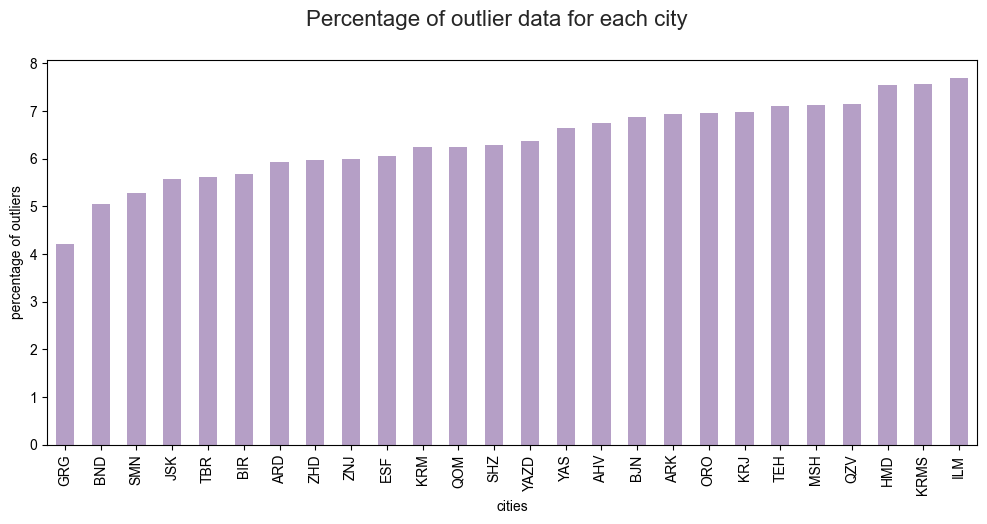

In [17]:
# Ploting outlier percentage of each city.

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(outlier_perc, color='indigo',width=0.51, alpha=0.4)
sns.set_style("darkgrid")

ax.set_xlabel('cities')
ax.set_xticks(ticks=range(len(outlier_perc)), labels=outlier_perc.keys(), rotation=90)
ax.set_ylabel('percentage of outliers')
fig.suptitle('Percentage of outlier data for each city', fontsize=16)
pass

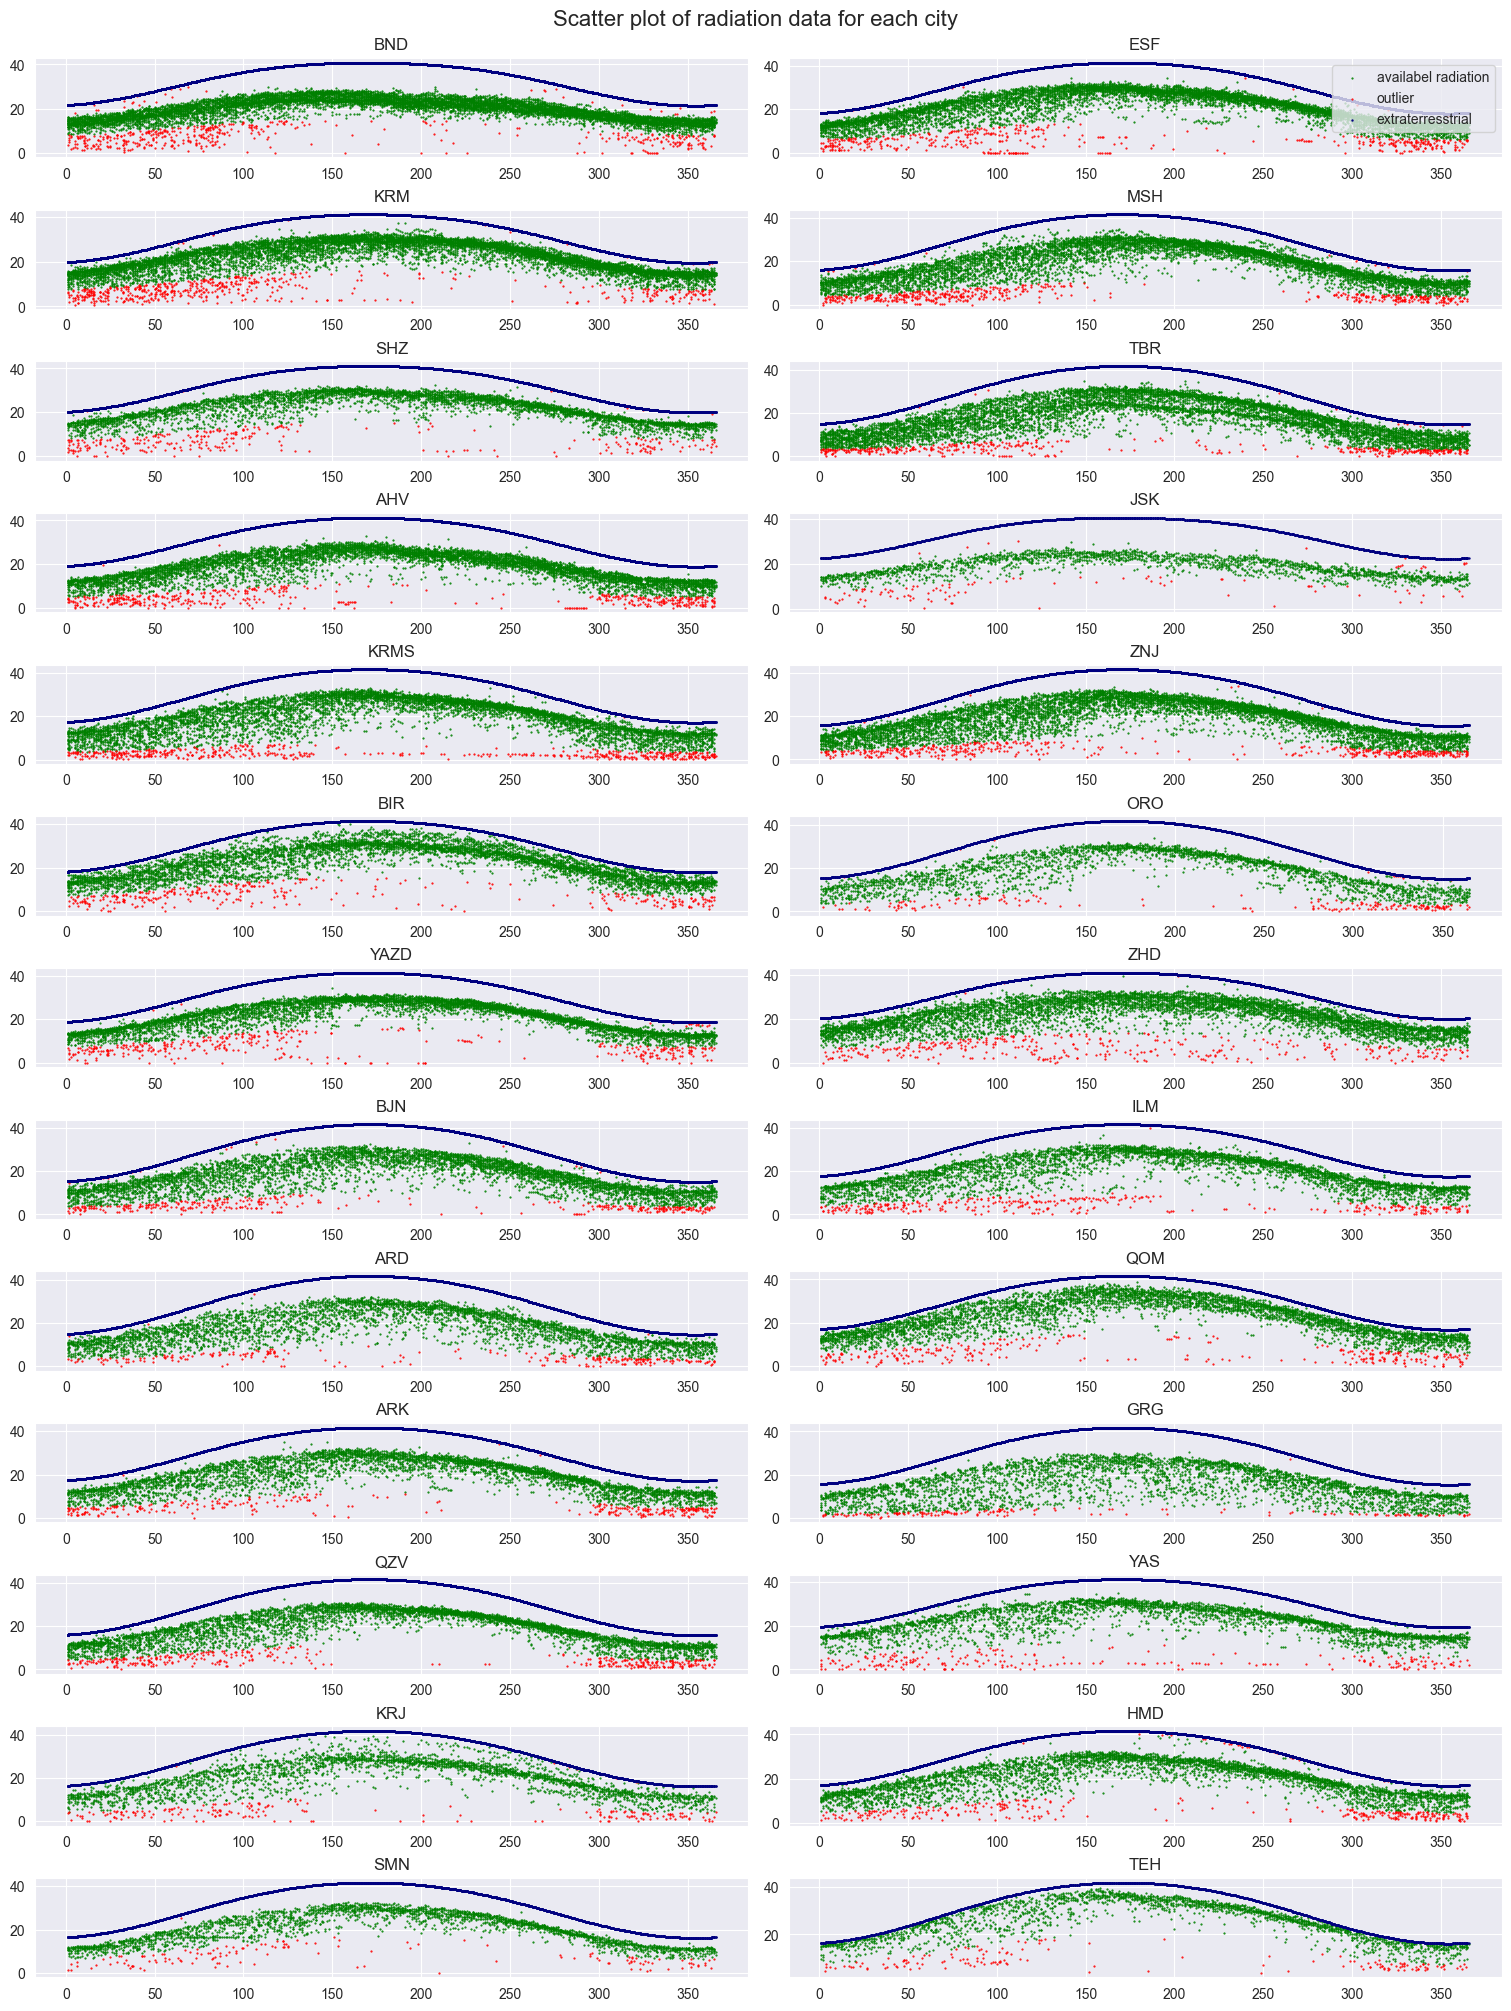

In [18]:
# Scatter ploting each city's available radiation,
# and labeling them if they are considered outlier or not.
# Scatter ploting extratrestrial radiation.

fig, axes = plt.subplots(13, 2, figsize=(15, 20), layout='constrained')

for ax, city in zip(axes.ravel(), cities):
    city_data = data.where(data.city == city)
    outliers = city_data[city_data.outlier == True]
    valids = city_data[city_data.outlier == False]
    
    ax.scatter(valids.doy, valids.ava_rad, s=0.3, c='green', label='availabel radiation')
    ax.scatter(outliers.doy, outliers.ava_rad, s=0.3, c='red', label='outlier')
    ax.scatter(city_data.doy, city_data.et_rad, s=0.5, c='navy', label='extraterresstrial')
    ax.set_title(city)
    
axes.ravel()[1].legend(loc='upper right')
fig.suptitle('Scatter plot of radiation data for each city', fontsize=16)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
pass

## Interpreting above plot:

By observing outliers distribution in the plot, we can sea that outliers are mostly located
between days 1 to 100 and 300 to 365, witch are fall and winter days. So it's possible that
these samples are not wrong, and they just have low values because they were measured
on cloudy days!

So we just keep these samples in the DataFrame!

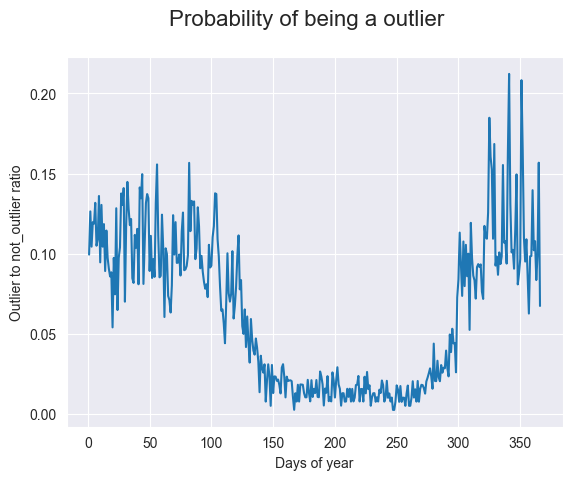

In [19]:
# Finding out the average ratio of outliers sampels to not_outliers sampels for each day of year

outlier_per_day = data.groupby(['doy']).outlier.mean()

outlier_per_day.plot()
plt.xlabel('Days of year')
plt.ylabel('Outlier to not_outlier ratio')
plt.suptitle('Probability of being a outlier', fontsize=16)
pass

In [20]:
# Changing outlier name to cloudy in the DataFrame:

data.rename(columns = {'outlier': 'cloudy'}, inplace=True)

## Data visualization:

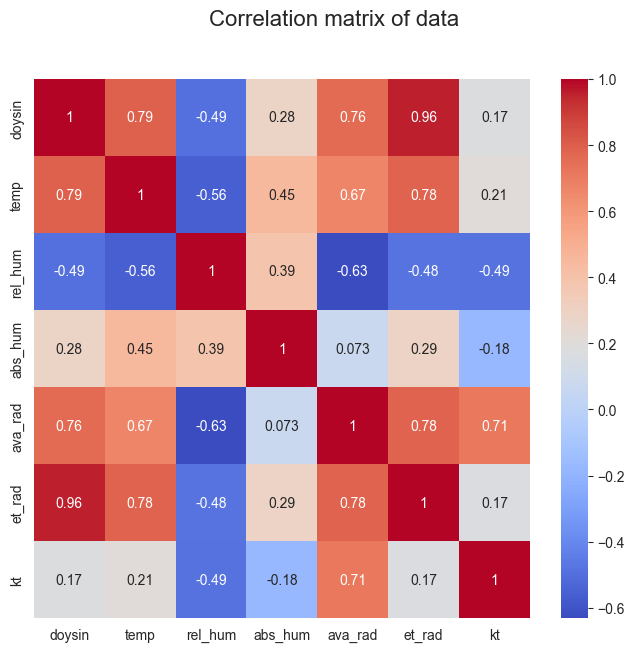

In [21]:
# Ploting correlation matrix.

corr = data[['doysin', 'temp', 'rel_hum', 'abs_hum', 'ava_rad', 'et_rad', 'kt']].corr()

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")
fig.suptitle('Correlation matrix of data', fontsize=16)
pass

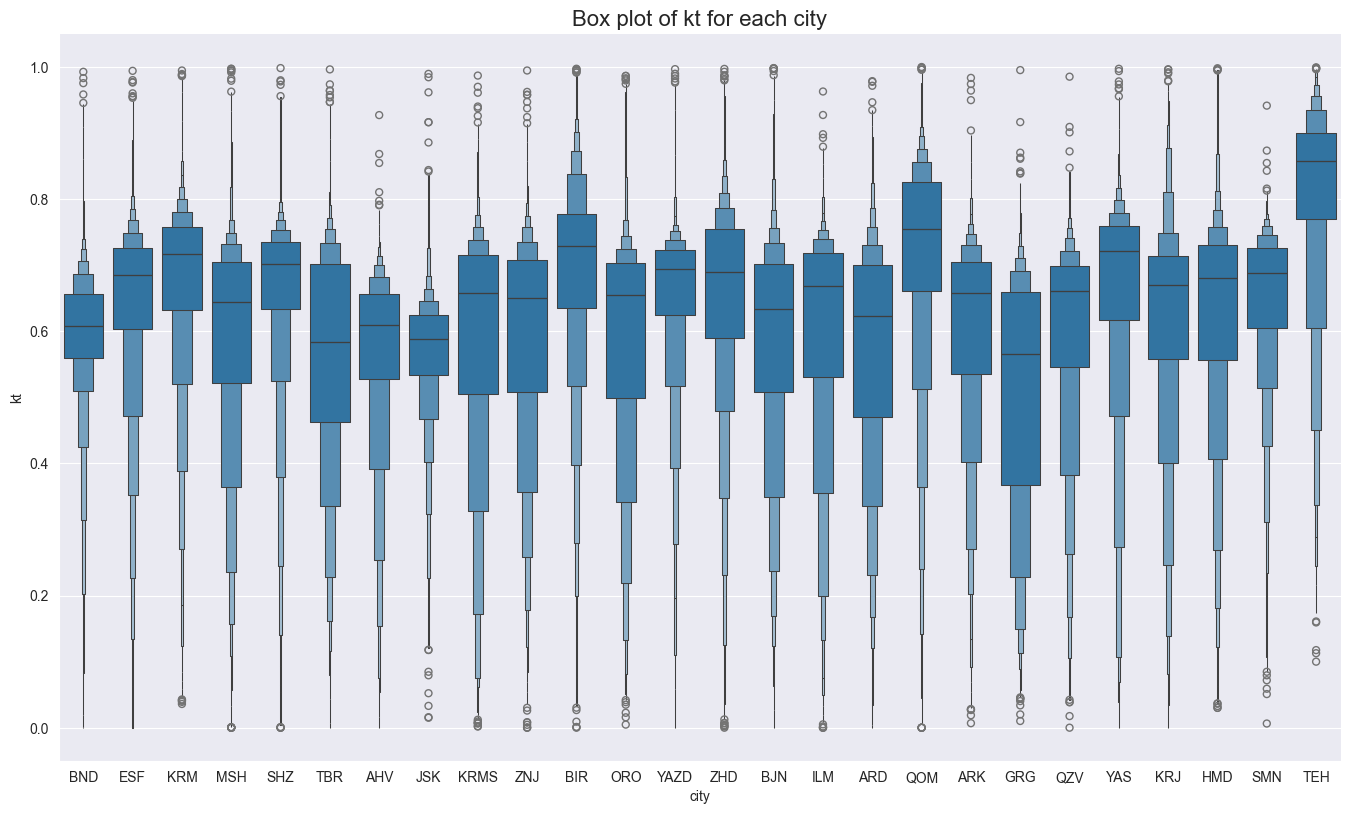

In [22]:
# Ploting distribution box plot of kt(clearness), for each city.

sns.catplot(data=data, x='city', y='kt', kind='boxen', height=8, aspect=1.7)
plt.title('Box plot of kt for each city', fontsize=16)
pass

### Removing TEH(Tehran city) from data:

Since kt values of tehran are much higher than other cities,
it's data is not reliable and should be omited!

In [23]:
data = data[data.city != 'TEH']
cities = data.city.unique()

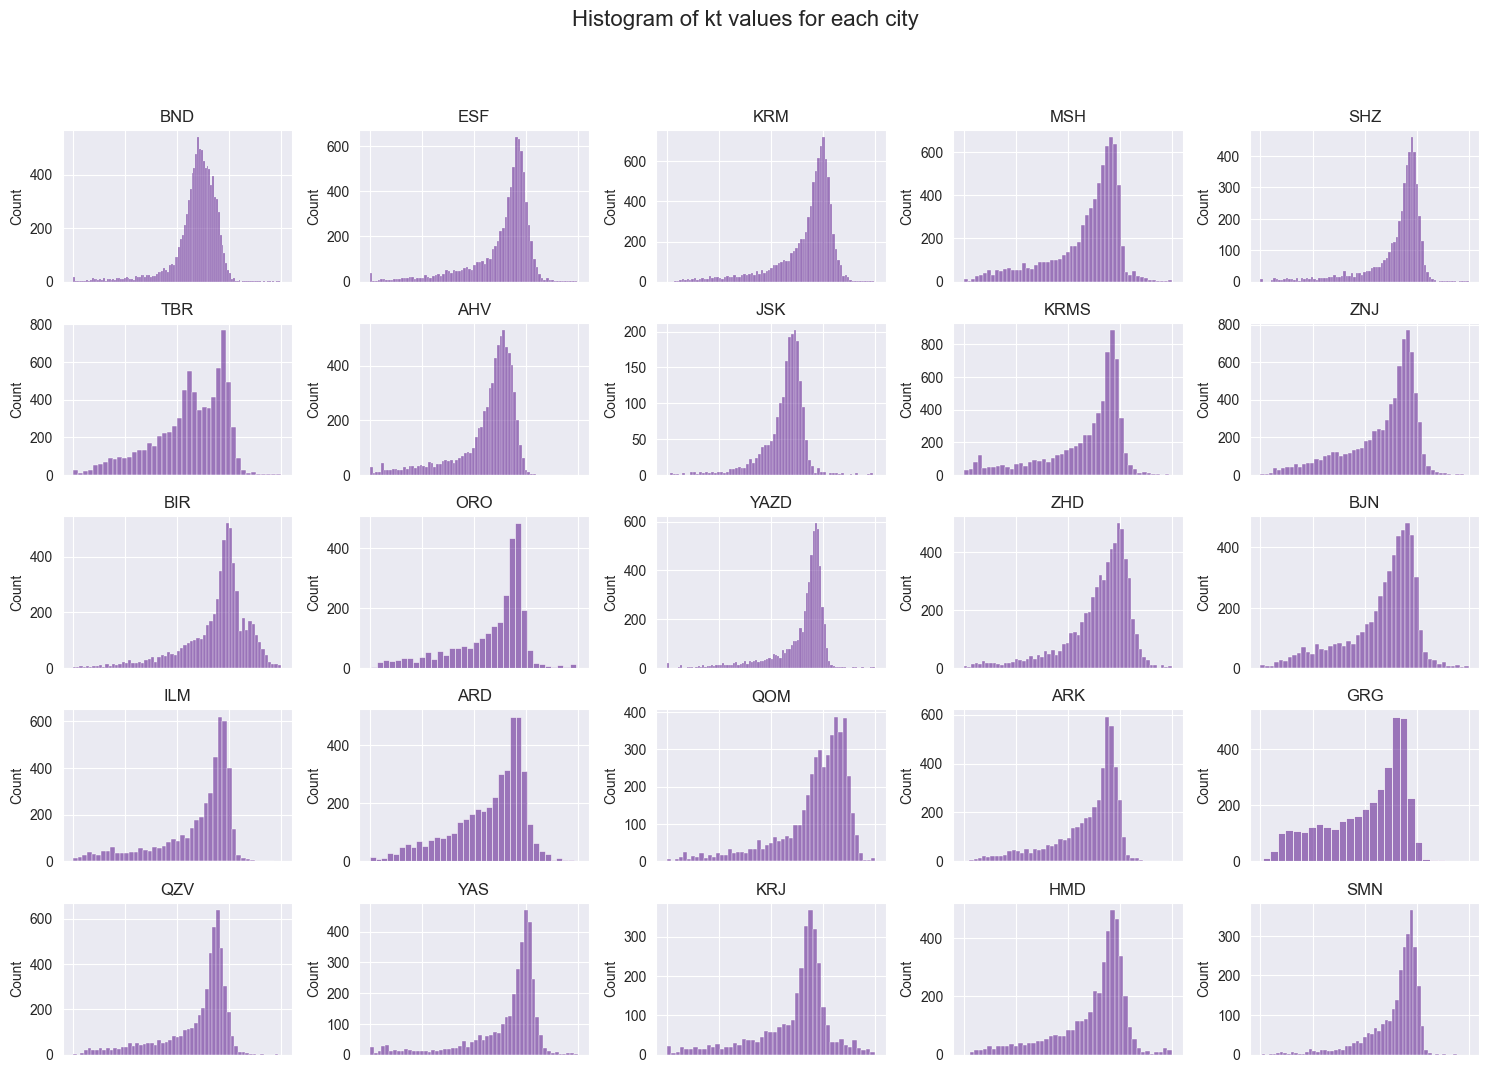

In [24]:
# Histogram ploting kt values for each city.

fig, axes = plt.subplots(7, 5, figsize=(15, 15), sharex=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    sns.histplot(city_data.kt, color='indigo', alpha=0.5, ax=ax)
    ax.set_title(city)

fig.suptitle('Histogram of kt values for each city', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
pass

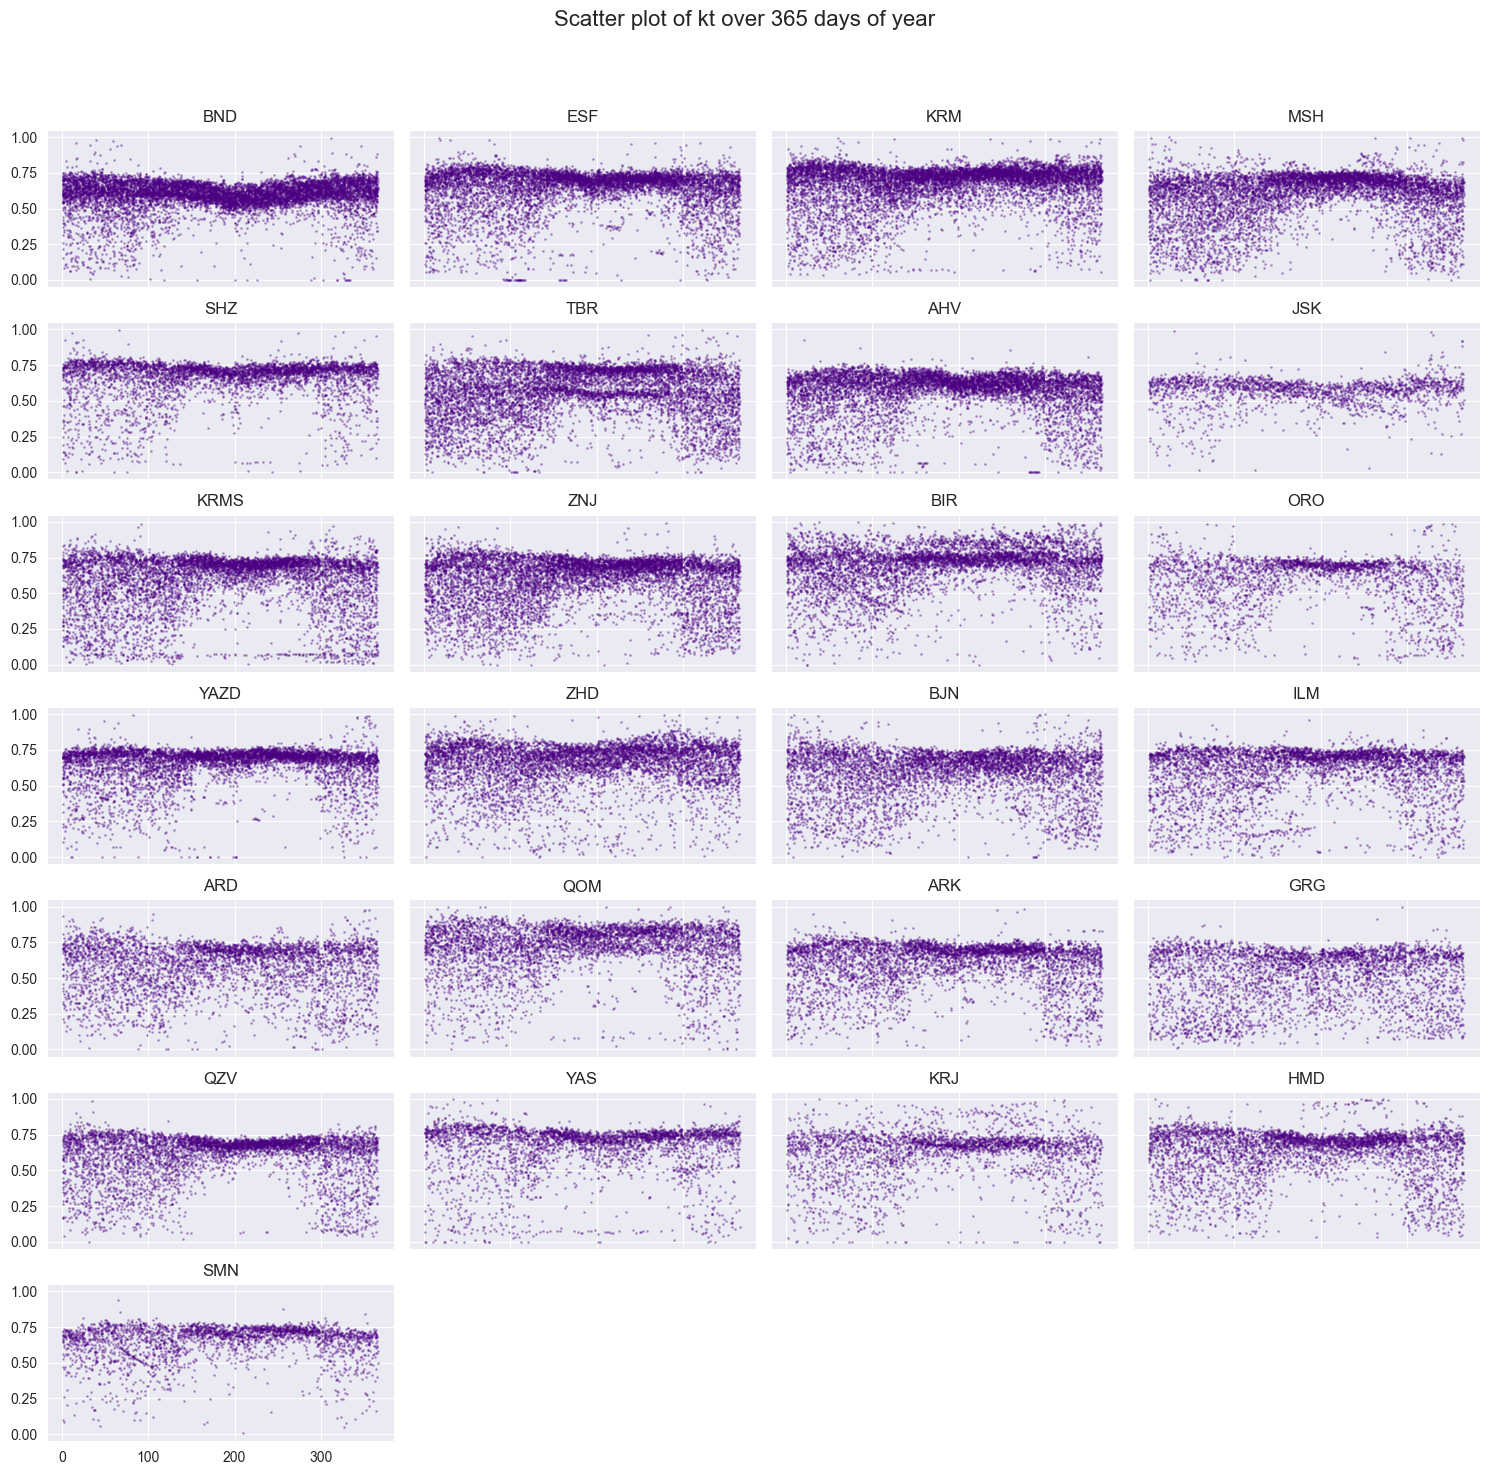

In [25]:
# Scatter ploting kt(clearness) and doy(day of year), for each city.

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True, sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    ax.scatter(city_data.doy, city_data.kt, color='indigo', alpha=0.3, s=1)
    ax.set_title(city)

fig.suptitle('Scatter plot of kt over 365 days of year', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
pass

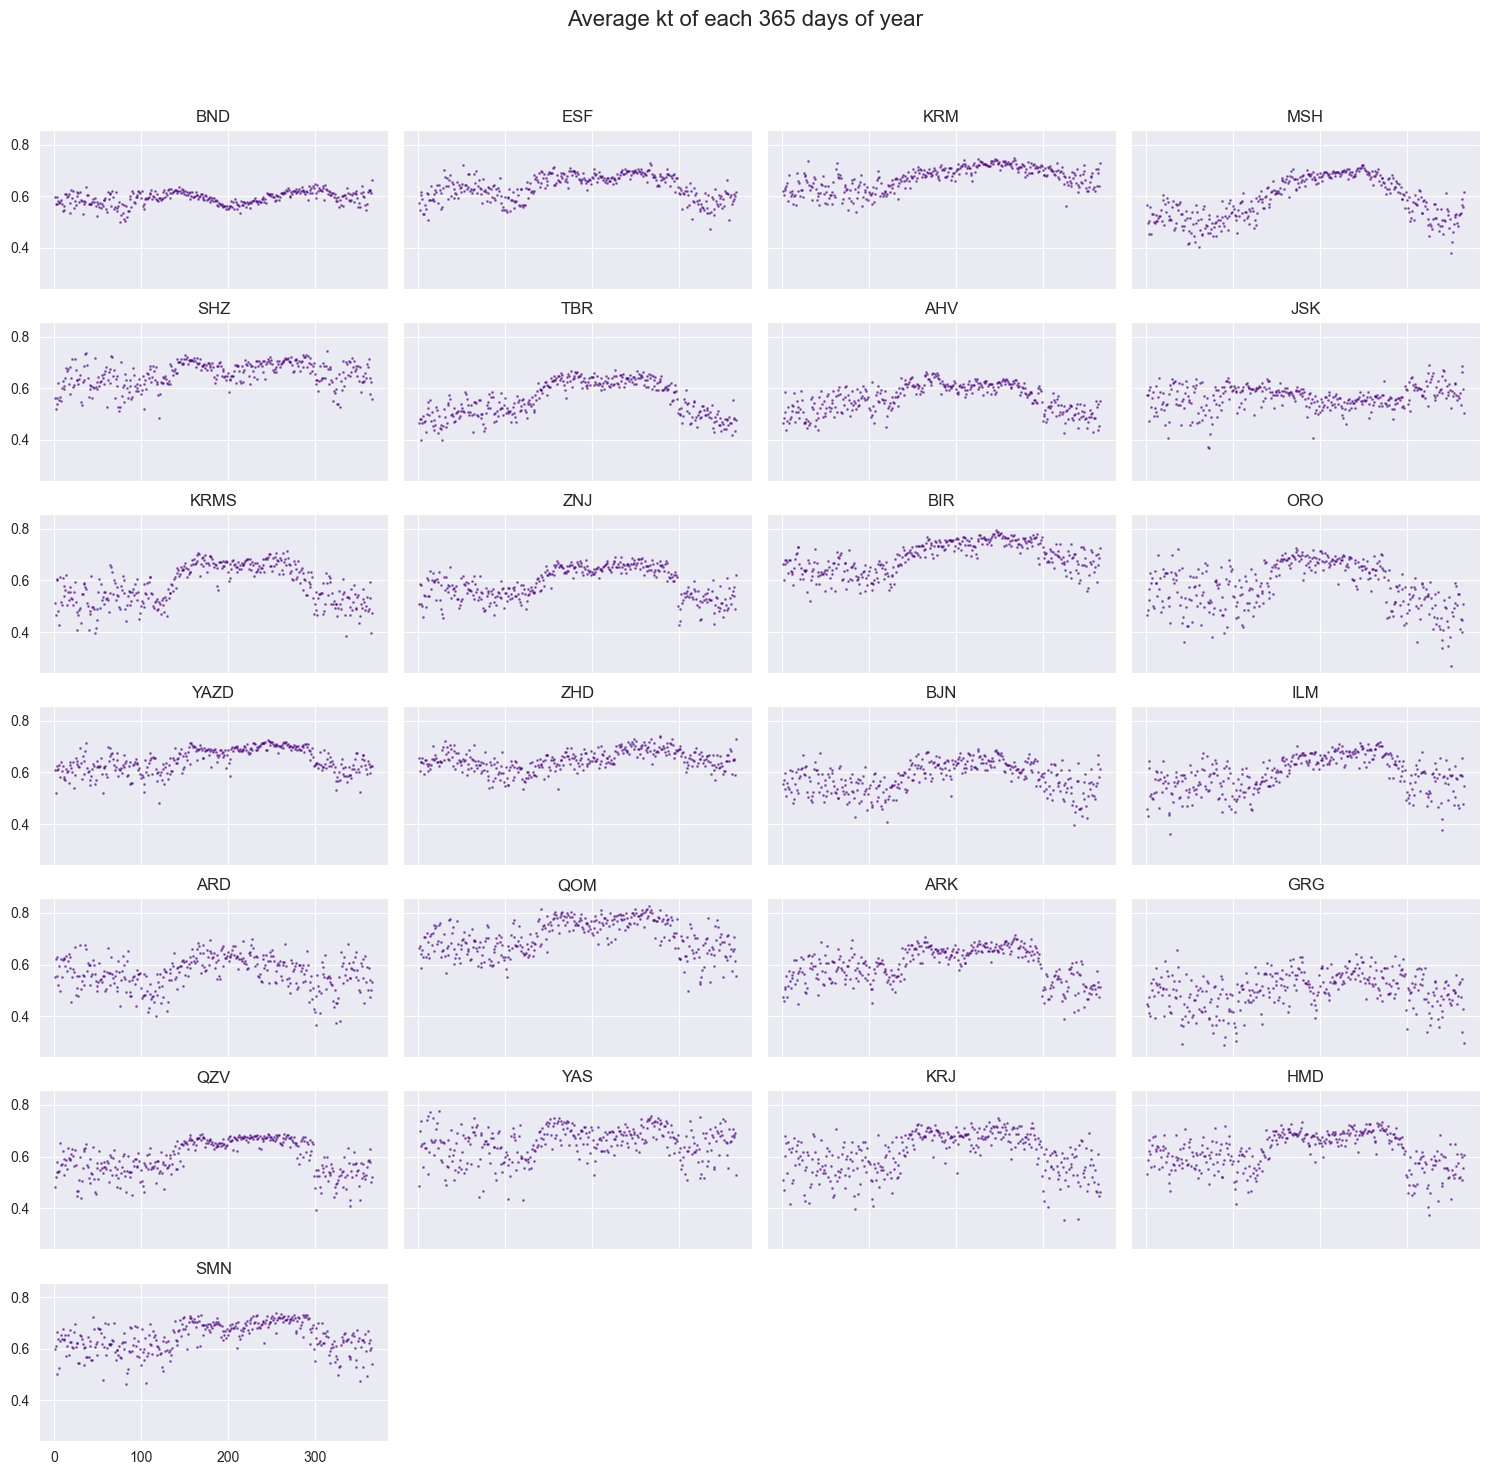

In [26]:
# Averaging kt over year for each city, and scatter ploting it.

daily_avr_kt = data.groupby(['doy', 'city']).kt.mean()
daily_avr_kt = pd.DataFrame(daily_avr_kt)
daily_avr_kt.reset_index(inplace=True)

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharex=True, sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = daily_avr_kt[daily_avr_kt.city == city]
    ax.scatter(city_data.doy, city_data.kt, color='indigo', alpha=0.5, s=1)
    ax.set_title(city)

plt.suptitle('Average kt of each 365 days of year', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
pass

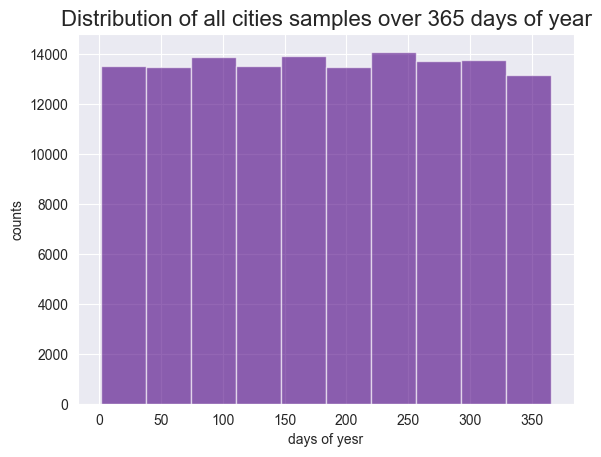

In [27]:
# Histogram ploting doy(day of year) of all cities.
# To observe the overal sampeling distribution.

plt.hist(data.doy, color='indigo', alpha=0.6)
plt.title('Distribution of all cities samples over 365 days of year', fontsize=16)
plt.xlabel('days of yesr')
plt.ylabel('counts')
pass

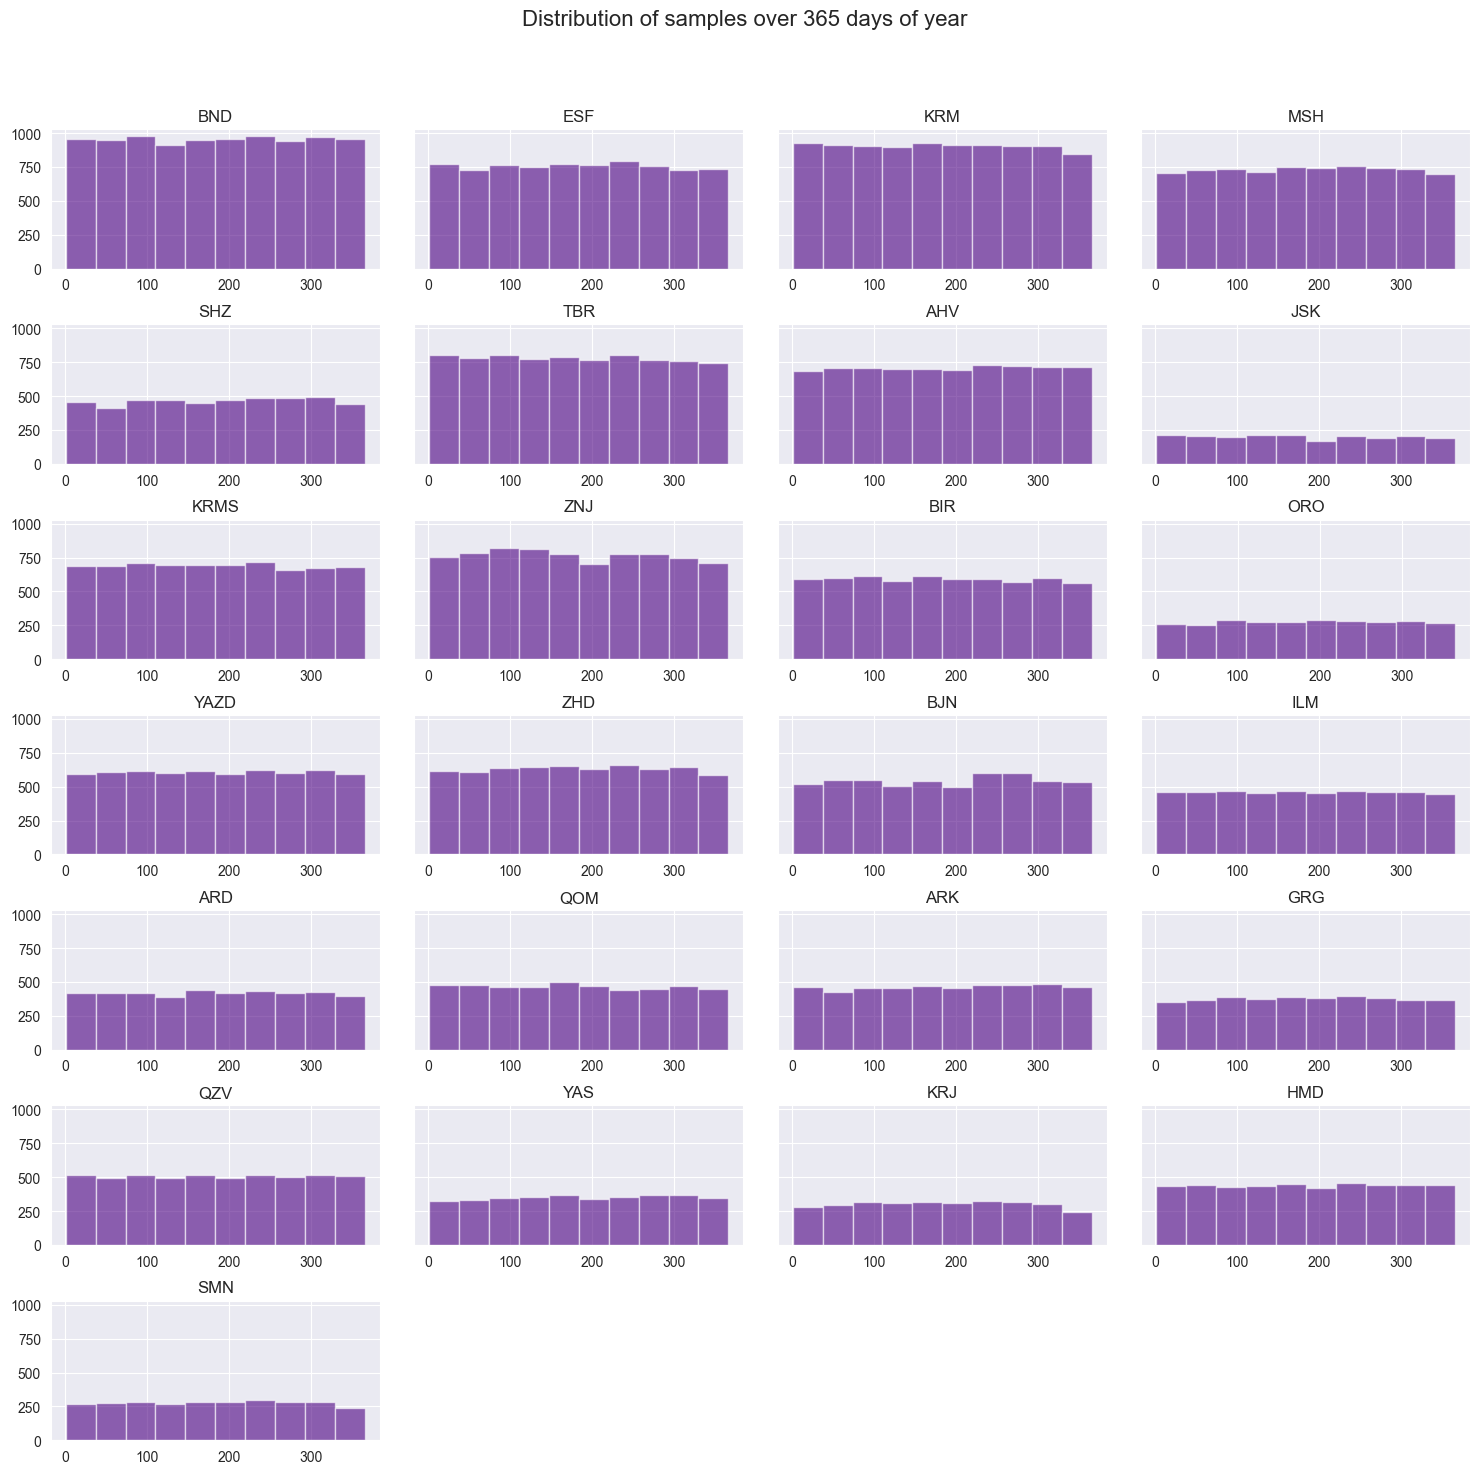

In [28]:
# Histogram ploting doy(day of year) for each city.
# To observe sampeling distribution.

fig, axes = plt.subplots(7, 4, figsize=(15, 15), sharey=True)

for city, ax in zip(cities, axes.ravel()):
    city_data = data[data.city == city]
    ax.hist(city_data.doy, color='indigo', alpha=0.6)
    ax.set_title(city)

fig.suptitle('Distribution of samples over 365 days of year', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
pass

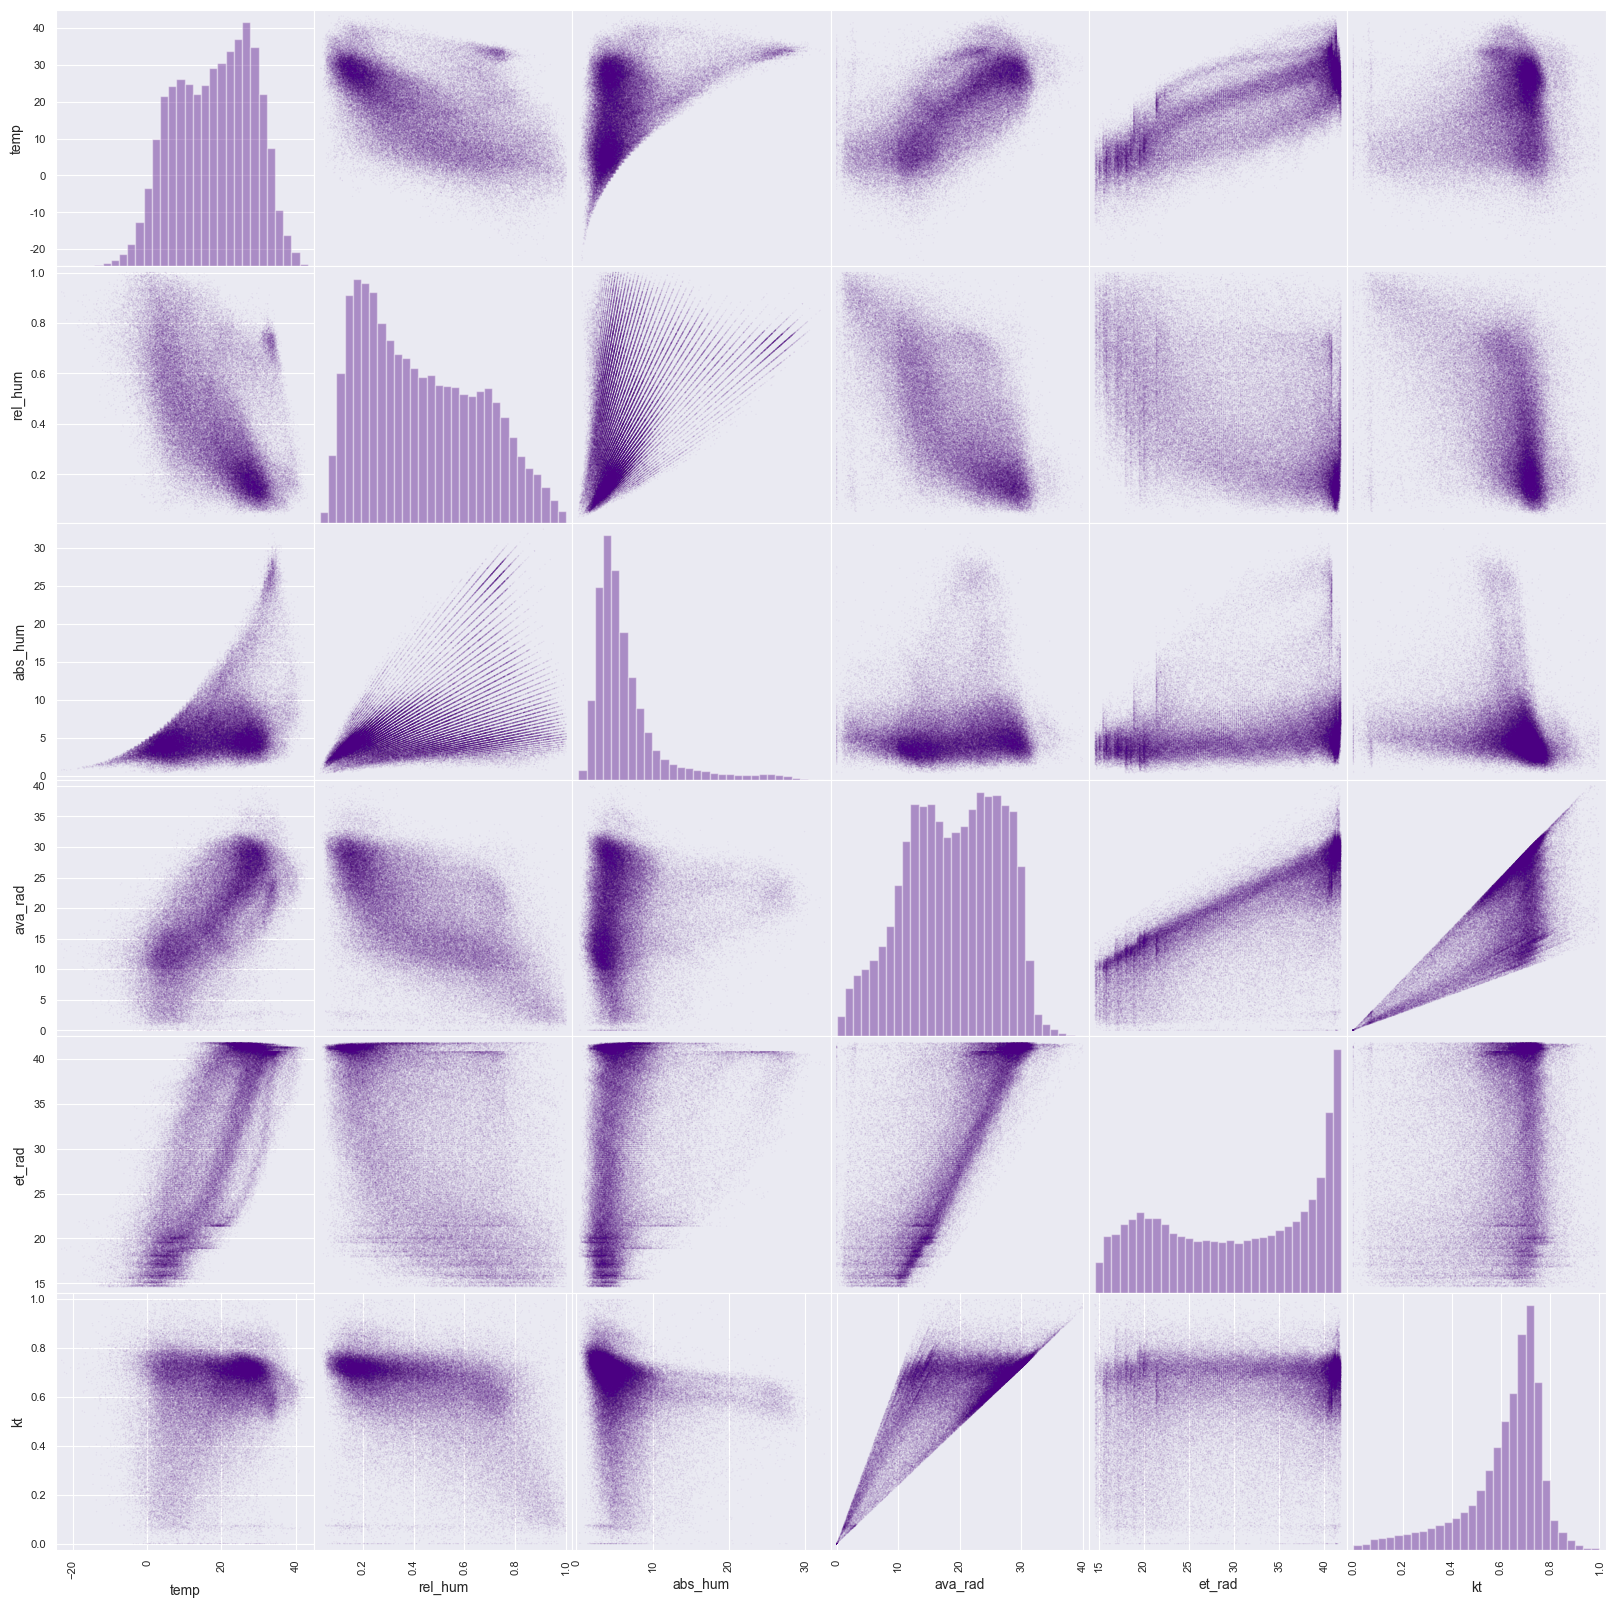

In [29]:
# Pair ploting data:

plot_data = data[['temp', 'rel_hum', 'abs_hum', 'ava_rad', 'et_rad', 'kt']]

pd.plotting.scatter_matrix(plot_data, figsize=(20,20), marker = 'o', color = 'indigo',
                           hist_kwds = {'bins': 30, 'color': 'indigo', 'alpha': 0.4},
                           s = 1, alpha = 0.05)
pass

In [30]:
# Pickling data as cleaned_data.pkl
# Outlier are removed from this data.

with open(r'..\data\interim\04_data_merging\cleaned_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Conclusion:
In this notebook:

1. All previous datasets are merged together.
2. Outliers are removed.
3. The final DataFramed is pickled for further processes.